python 3.7  

# 抓取数据

1. 发起请求获得响应 get
2. 解析数据
3. 保存数据

In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
# 具体是https://news.qq.com/zt2020/page/feiyan.htm#/global中的数据
url='https://news.qq.com/zt2020/page/feiyan.htm'

In [3]:
response = requests.get(url)

In [4]:
# 这一步响应码为200 说明响应成功。
response.status_code

200

### 分析爬取的页面


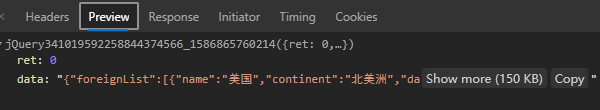
上方的js文件就是海外疫情数据源

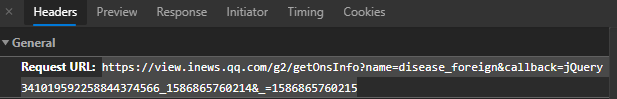

上方是js文件的请求url

经过以上分析，发现爬取的页面是动态页面（异步加载）。
所需数据在一个js文件中，并且知道了这个js文件的请求url，如下。

In [5]:
js_url = 'https://view.inews.qq.com/g2/getOnsInfo?name=disease_foreign&callback=jQuery341019592258844374566_1586865760214&_=1586865760215'

#### 修改js_url
1. js_url中包含了callback（回调函数）的调用,我们不需要，所以删掉jQuery341019592258844374566_1586865760214  
2. 因为js_url中的末尾部分的1586865760215表示时间戳，所以我们在这里替换为实时的时间戳。 

In [6]:
# 计算当前的时间戳
import time
timestamp = int(time.time()*1000)  # 根据已知的时间戳1586865760215是13位的整数

In [7]:
js_url = 'https://view.inews.qq.com/g2/getOnsInfo?name=disease_foreign&callback=&_=%d'%timestamp

In [8]:
response = requests.get(js_url)
if response.status_code ==200:
    print("response yes")
else:
    print("response no")

response yes


In [9]:
# js文件的响应是json。这里转换为dict类型
data_dict = response.json()
type(data_dict)

dict

###### 补充 ： dict保存到 json文件  ，从json文件 读入

##### json.dumps()和json.loads()
- json.dumps()和json.loads()是json格式处理函数（可以这么理解，json是字符串）
    - json.dumps()函数是将一个Python数据类型列表进行json格式的编码（可以这么理解，json.dumps()函数
是将字典转化为字符串）
    - json.loads()函数是将json格式数据转换为字典（可以这么理解，json.loads()函数是将字符串转化为字
典）
- json.dump()和json.load()主要用来读写json文件函数

In [10]:
import json
with open("./data_dict.json",'w',encoding='utf-8') as json_file:
        json.dump(data_dict,json_file,ensure_ascii=False)

In [11]:
with open("./data_json.json",'r',encoding='utf-8') as json_file:
        data_dict_read = json.load(json_file)

In [12]:
data_dict_read

{'ret': 0,
 'data': '{"foreignList":[{"name":"美国","continent":"北美洲","date":"03.30","isUpdated":false,"confirmAdd":0,"confirmAddCut":0,"confirm":143071,"suspect":0,"dead":2513,"heal":4856,"nowConfirm":135702,"confirmCompare":0,"nowConfirmCompare":0,"healCompare":0,"deadCompare":0,"children":[{"name":"纽约","date":"04.14","nameMap":"New York","isUpdated":false,"confirmAdd":0,"confirmAddCut":0,"confirm":196146,"suspect":0,"dead":10058,"heal":26463},{"name":"新泽西","date":"04.14","nameMap":"New Jersey","isUpdated":false,"confirmAdd":0,"confirmAddCut":0,"confirm":64584,"suspect":0,"dead":2443,"heal":355},{"name":"马萨诸塞","date":"04.14","nameMap":"Massachusetts","isUpdated":false,"confirmAdd":0,"confirmAddCut":0,"confirm":26867,"suspect":0,"dead":844,"heal":729},{"name":"密歇根州","date":"04.14","nameMap":"Michigan","isUpdated":false,"confirmAdd":0,"confirmAddCut":0,"confirm":25635,"suspect":0,"dead":1602,"heal":433},{"name":"加利福尼亚","date":"04.14","nameMap":"California","isUpdated":false,"confirmAdd":

###  补充：用selenium+pandas 抓取动态页面

反扒机制厉害，所以找不到js文件请求的话？可以尝试这种方法。

思路：selenium抓取整个页面，然后用pandas将表格读出来。
- selenium自动化测试工具，它可以驱动web浏览器。
- 使用pandas来处理表格（要抓取的数据是表格数据,相对而言，如果用xpath方法则比较麻烦）

In [13]:
from selenium import webdriver
import pandas as pd

In [14]:
# 需要指明Webdirver的路径（webdirver由浏览器官方提供，注意和浏览器的版本一致）。
driver_url = r"C:\Program Files (x86)\Microsoft\Edge\Application\msedgedriver.exe"
# 打开浏览器窗口
driver = webdriver.Edge(executable_path=driver_url)
# 并打开特定网页
driver.get(url)

In [15]:
# 从dirver.page_source属性，获得网页html
html = driver.page_source

In [16]:
# 关闭浏览器窗口
driver.close()

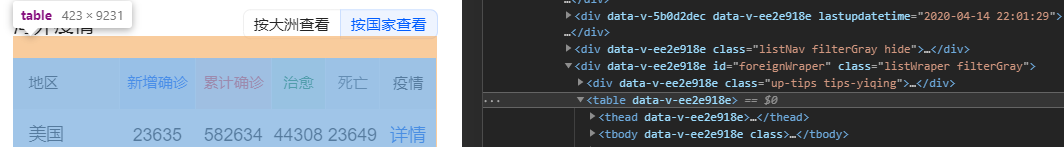
     
     找到数据所在table

In [17]:
# 定位并读取数据所在的table。   
soup = BeautifulSoup(html,'lxml')  # 使用lxml解析器去解析html 
table = soup.find('div',class_="listWraper filterGray").find('table')

In [18]:
type(table)

bs4.element.Tag

In [19]:
# prettify()方法读到得是列表，由于只有一个表格，所以[0]
data_df = pd.read_html(table.prettify())[0]

In [20]:
data_df.head()

,地区,新增确诊,累计确诊,治愈,死亡,疫情
0,美国,31411,671425,56236,33286,详情
1,西班牙,2132,184948,74797,19315,详情
2,意大利,3786,168941,40164,22170,详情
3,法国,4560,147091,33327,17941,详情
4,德国,2586,138135,81800,4093,详情


In [21]:
# 可以用下面的方式，去除最后一列
data_df = data_df.iloc[:,0:len(data_df.columns)-1]
data_df.head()

,地区,新增确诊,累计确诊,治愈,死亡
0,美国,31411,671425,56236,33286
1,西班牙,2132,184948,74797,19315
2,意大利,3786,168941,40164,22170
3,法国,4560,147091,33327,17941
4,德国,2586,138135,81800,4093


###### 补充:  DataFrame数据的保存与读取

In [22]:
data_df.to_json('./data_df.json')

In [23]:
data_df_read = pd.read_json('./data_df.json',orient='values',encoding='utf-8')

In [24]:
data_df_read.head()

,地区,新增确诊,累计确诊,治愈,死亡
0,美国,31411,671425,56236,33286
1,西班牙,2132,184948,74797,19315
10,加拿大,2594,30973,9729,1231
100,约旦,1,402,259,7
101,格鲁吉亚,34,370,77,3
